In [1]:
#Data analysis and math
import math
from math import sqrt
import datetime
import numpy as np
import pandas as pd
from scipy import stats as st
import statsmodels.api as sm

#Preprocessing
from scipy.stats import mstats

# For non-seasonal data
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
sns.set_context({"figure.figsize": (15, 7.5)})

C:\Users\Jorda\Anaconda3\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


** Call Functions **

** Read in Data **

In [2]:
price = pd.read_csv('TS1.csv')

In [3]:
#Examine columns, missing values, and data types
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8750 entries, 0 to 8749
Data columns (total 2 columns):
date     8750 non-null object
price    8750 non-null float64
dtypes: float64(1), object(1)
memory usage: 136.8+ KB


** Data Cleaning**

Convert date column in datasets to datetime and sort in ascending order

In [4]:
price['date'] = pd.to_datetime(price['date'])

price = price.sort_values(['date'])


Round datetime values down to nearest hour in order to merge datasets on a common index

In [5]:
price['date'] = price['date'].map(lambda x: x.replace(minute=0, second=0, microsecond=0))

Set date as index and restrict data sets for dates in the calendar year 2016. Merge filtered 2016 datasets to single dataset

In [6]:
price.set_index('date',inplace=True)

In [7]:
price_16 = price.loc['2016-01-01 00:00:00':'2016-12-31 23:00:00']

In [8]:
df = price_16

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8750 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 1 columns):
price    8750 non-null float64
dtypes: float64(1)
memory usage: 136.7 KB


**Outlier adjustments**

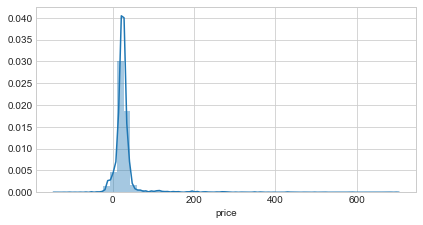

In [10]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.distplot(df['price'])


In [11]:
df.describe()

,price
count,8750.000000
mean,28.360163
std,40.668379
min,-141.936123
25%,17.578296
50%,23.860545
75%,29.874502
max,699.391742


In [12]:
df['price'] = mstats.winsorize(df['price'], limits=[0.05, 0.05])

Forecasting price should now feel less impacted by the outliers

In [13]:
df.describe()

,price
count,8750.000000
mean,23.668046
std,11.796162
min,-1.670591
25%,17.578296
50%,23.860545
75%,29.874502
max,49.391338


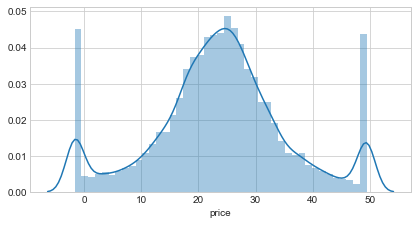

In [14]:
fig = plt.figure()

ax1 = fig.add_subplot(221)
sns.distplot(df['price'])

** Data Exploration **

## Seasonal ARIMA Plots

We will look at only January for visualizaton simplicity

In [15]:
timeseries = df['price']
timeseries = timeseries.loc['2016-01-01 00:00:00':'2016-01-31 23:00:00']

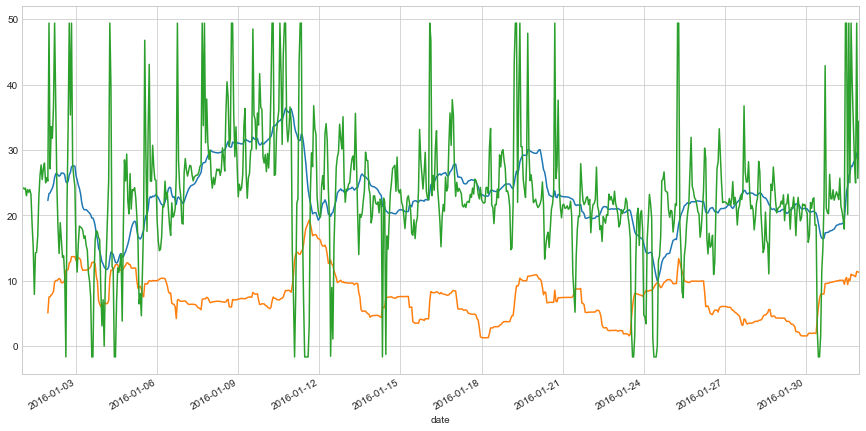

In [16]:
timeseries.rolling(24).mean().plot(label='24 Hour Rolling Mean')
timeseries.rolling(24).std().plot(label='24 Hour Rolling Std')
timeseries.plot()


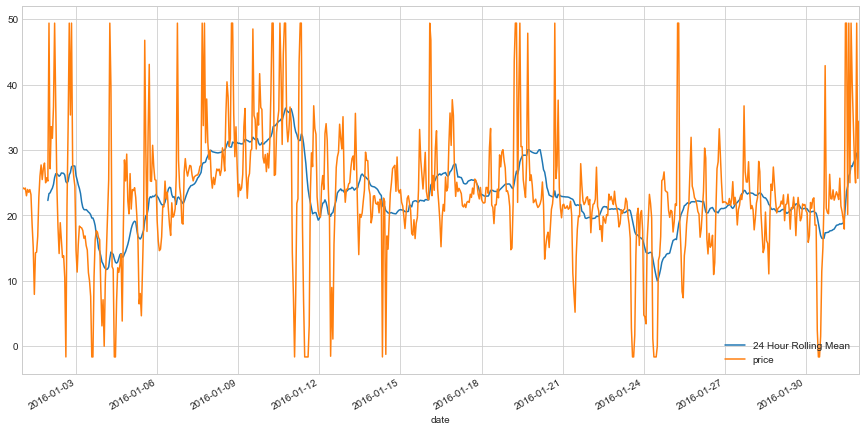

In [17]:
timeseries.rolling(24).mean().plot(label='24 Hour Rolling Mean')
timeseries.plot()
plt.legend()

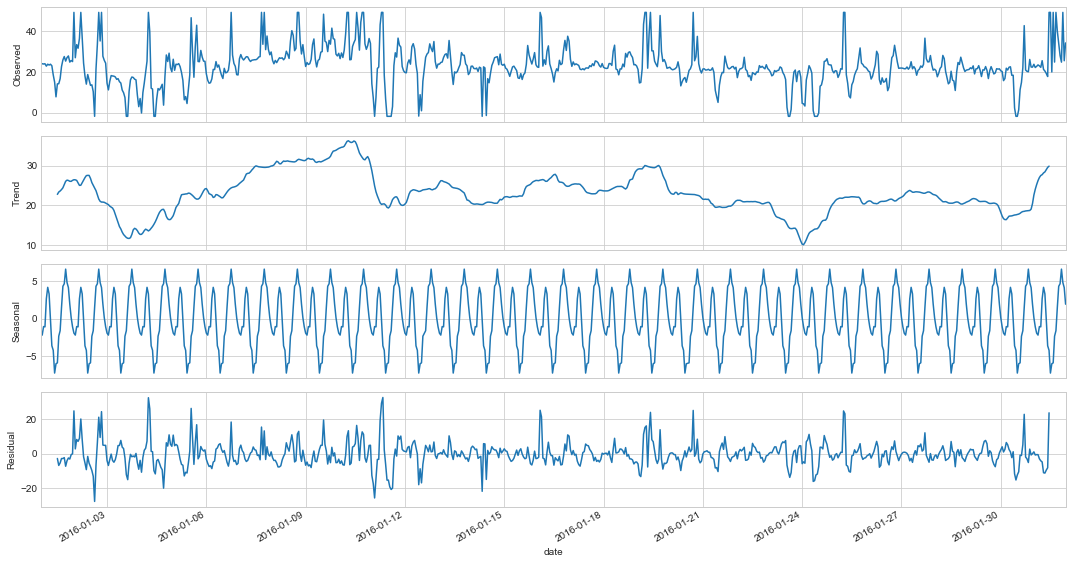

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(timeseries, freq=24)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
result = adfuller(df['price'])

In [21]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.83230096186
p-value : 1.75643754157e-14
#Lags Used : 28
Number of Observations Used : 8721
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [22]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

**First Difference**

In [23]:
timeseries = pd.DataFrame(timeseries)

In [24]:
timeseries['Price First Difference'] = timeseries['price'] - timeseries['price'].shift(1)

In [25]:
adf_check(timeseries['Price First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.1505329049
p-value : 7.97312346939e-18
#Lags Used : 20
Number of Observations Used : 720
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


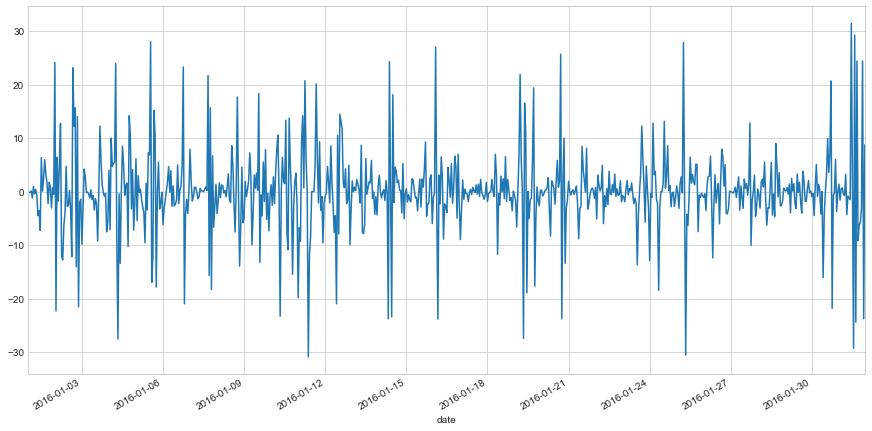

In [26]:
timeseries['Price First Difference'].plot()

**Second Difference**

In [27]:
timeseries['Price Second Difference'] = timeseries['Price First Difference'] - timeseries['Price First Difference'].shift(1)

In [28]:
adf_check(timeseries['Price Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.016587825
p-value : 3.63367744262e-26
#Lags Used : 16
Number of Observations Used : 723
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


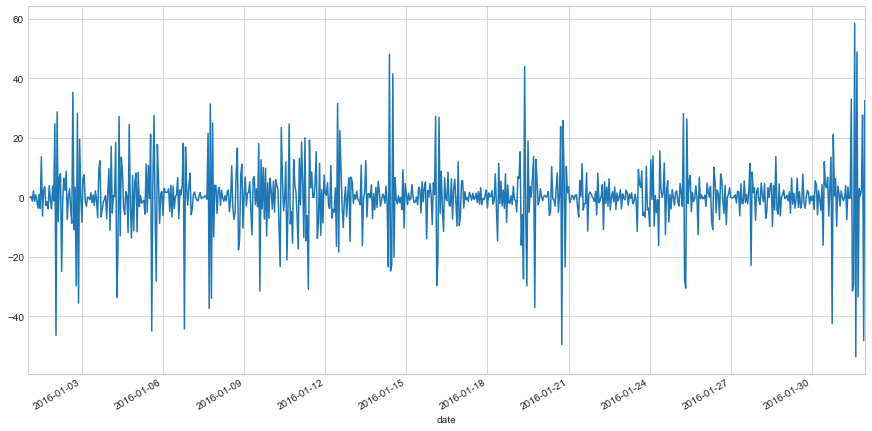

In [29]:
timeseries['Price Second Difference'].plot()

**Seasonal Difference**

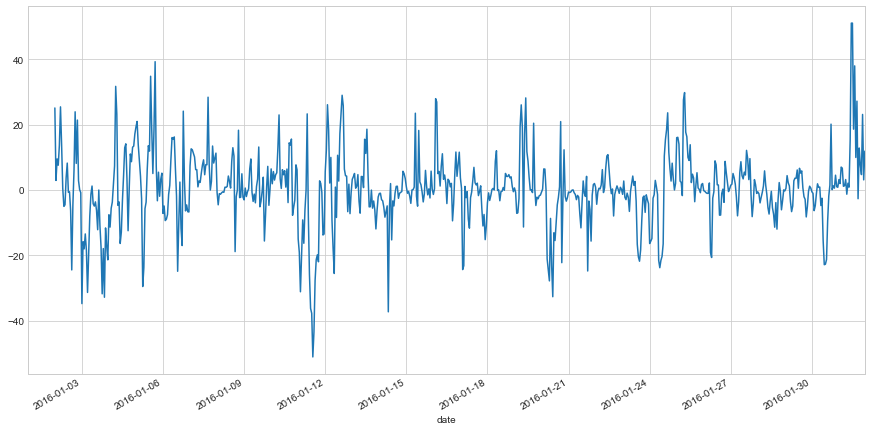

In [30]:
timeseries['Seasonal Difference'] = timeseries['price'] - timeseries['price'].shift(24)
timeseries['Seasonal Difference'].plot()

In [31]:
# Seasonal Difference by itself was not enough!
adf_check(timeseries['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -12.7704701279
p-value : 7.79059840587e-24
#Lags Used : 0
Number of Observations Used : 717
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


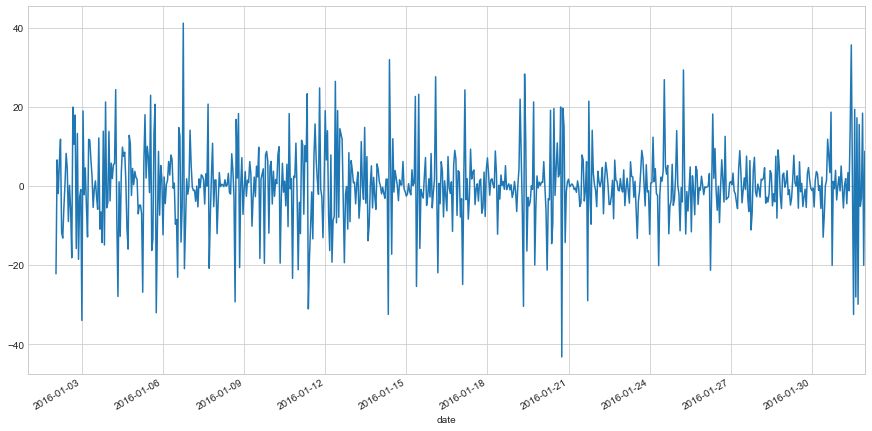

In [32]:
# You can also do seasonal first difference
timeseries['Seasonal First Difference'] = timeseries['Price First Difference'] - timeseries['Price First Difference'].shift(24)
timeseries['Seasonal First Difference'].plot()

In [33]:
adf_check(timeseries['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -9.35051127497
p-value : 8.32023258836e-16
#Lags Used : 17
Number of Observations Used : 699
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


**Correlation Plots**

In [34]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

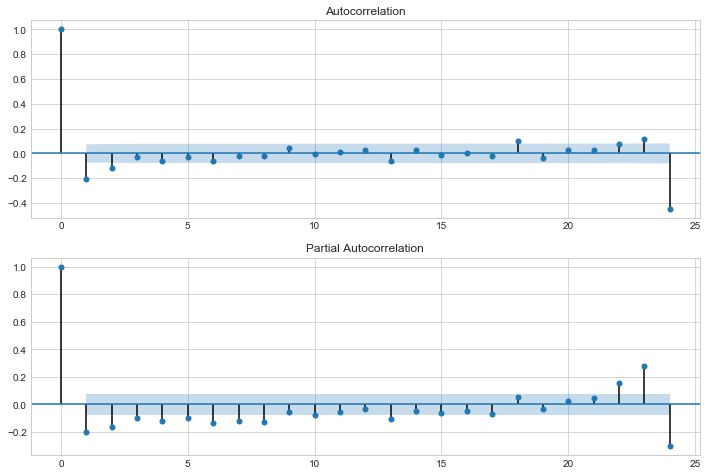

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(timeseries['Seasonal First Difference'].iloc[25:], lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(timeseries['Seasonal First Difference'].iloc[25:], lags =24, ax=ax2)